### Crop Pest and Disease

## Import Library & Dataset

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import cv2
from PIL import Image, UnidentifiedImageError, ImageEnhance, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = False
from pathlib import Path
from collections import Counter, defaultdict
import hashlib
import shutil
from tqdm import tqdm
import random
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers, models
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

## Model: InceptionV3

In [ ]:
IMG_SIZE = (299, 299)
BATCH_SIZE = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset_split/train",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset_split/val",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset_split/test",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

Found 16839 files belonging to 22 classes.
Found 3598 files belonging to 22 classes.
Found 3634 files belonging to 22 classes.


In [3]:
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)
print(num_classes)

['Cashew anthracnose', 'Cashew gumosis', 'Cashew healthy', 'Cashew leaf miner', 'Cashew red rust', 'Cassava bacterial blight', 'Cassava brown spot', 'Cassava green mite', 'Cassava healthy', 'Cassava mosaic', 'Maize fall armyworm', 'Maize grasshoper', 'Maize healthy', 'Maize leaf beetle', 'Maize leaf blight', 'Maize leaf spot', 'Maize streak virus', 'Tomato healthy', 'Tomato leaf blight', 'Tomato leaf curl', 'Tomato septoria leaf spot', 'Tomato verticulium wilt']
22


In [4]:
train_ds = train_ds.map(lambda x, y: (preprocess_input(x), y))
val_ds   = val_ds.map(lambda x, y: (preprocess_input(x), y))
test_ds  = test_ds.map(lambda x, y: (preprocess_input(x), y))

In [5]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.shuffle(1000).prefetch(AUTOTUNE)
val_ds   = val_ds.prefetch(AUTOTUNE)
test_ds  = test_ds.prefetch(AUTOTUNE)

InceptionV3 default input size 299 x 299

In [13]:
pretrained_model = InceptionV3(
    include_top=False,
    weights='imagenet',
    input_shape = IMG_SIZE + (3,)
)

pretrained_model.trainable = True

for layer in pretrained_model.layers[:249]:
    layers.trainable = False # Frezze awal (249 layer)

for layer in pretrained_model.layers[249:]:
    layers.trainable = True # Unfrezze later akhir

In [14]:
model = models.Sequential([
    pretrained_model, 
    layers.GlobalAveragePooling2D(), 
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 5, 5, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 22)             │        11,286 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,863,158 (87.22 MB)

 Trainable params: 22,828,726 (87.08 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [15]:
train_labels_list = []

for _, labels in train_ds.unbatch():
    train_labels_list.append(int(labels.numpy()))

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.arange(num_classes),
    y=train_labels_list
)

class_weights = dict(enumerate(class_weights))
print(class_weights)

{0: np.float64(0.6325694966190833), 1: np.float64(2.7934638354346384), 2: np.float64(0.7998005129666572), 3: np.float64(0.7939928328932478), 4: np.float64(0.6508580705009277), 5: np.float64(0.42194547459156057), 6: np.float64(0.746740576496674), 7: np.float64(1.079561482241313), 8: np.float64(0.9166575939031029), 9: np.float64(0.9838163122224819), 10: np.float64(3.865702479338843), 11: np.float64(1.62507237984945), 12: np.float64(5.390204865556978), 13: np.float64(1.1721425588194347), 14: np.float64(1.394187779433681), 15: np.float64(1.0660293745251963), 16: np.float64(1.194085945255992), 17: np.float64(2.3623737373737375), 18: np.float64(0.8514005460612802), 19: np.float64(2.1440030557677616), 20: np.float64(0.47689039932030586), 21: np.float64(1.4174242424242425)}


In [ ]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

In [20]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    class_weight=class_weights,
    callbacks=[early_stopping]
)

Epoch 1/20
527/527 ━━━━━━━━━━━━━━━━━━━━ 881s 2s/step - accuracy: 0.5270 - loss: 1.3906 - val_accuracy: 0.3816 - val_loss: 7.4709
Epoch 2/20
527/527 ━━━━━━━━━━━━━━━━━━━━ 944s 2s/step - accuracy: 0.6787 - loss: 0.8417 - val_accuracy: 0.6326 - val_loss: 1.2532
Epoch 3/20
527/527 ━━━━━━━━━━━━━━━━━━━━ 928s 2s/step - accuracy: 0.7261 - loss: 0.7096 - val_accuracy: 0.5425 - val_loss: 1.5776
Epoch 4/20
527/527 ━━━━━━━━━━━━━━━━━━━━ 757s 1s/step - accuracy: 0.7484 - loss: 0.6595 - val_accuracy: 0.6898 - val_loss: 0.9420
Epoch 5/20
527/527 ━━━━━━━━━━━━━━━━━━━━ 939s 2s/step - accuracy: 0.7818 - loss: 0.5566 - val_accuracy: 0.7265 - val_loss: 0.7998
Epoch 6/20
527/527 ━━━━━━━━━━━━━━━━━━━━ 1369s 3s/step - accuracy: 0.7920 - loss: 0.5282 - val_accuracy: 0.7104 - val_loss: 0.8608
Epoch 7/20
527/527 ━━━━━━━━━━━━━━━━━━━━ 1885s 4s/step - accuracy: 0.8220 - loss: 0.4292 - val_accuracy: 0.6940 - val_loss: 0.9383
Epoch 8/20
527/527 ━━━━━━━━━━━━━━━━━━━━ 790s 1s/step - accuracy: 0.8257 - loss: 0.4299 - val_ac

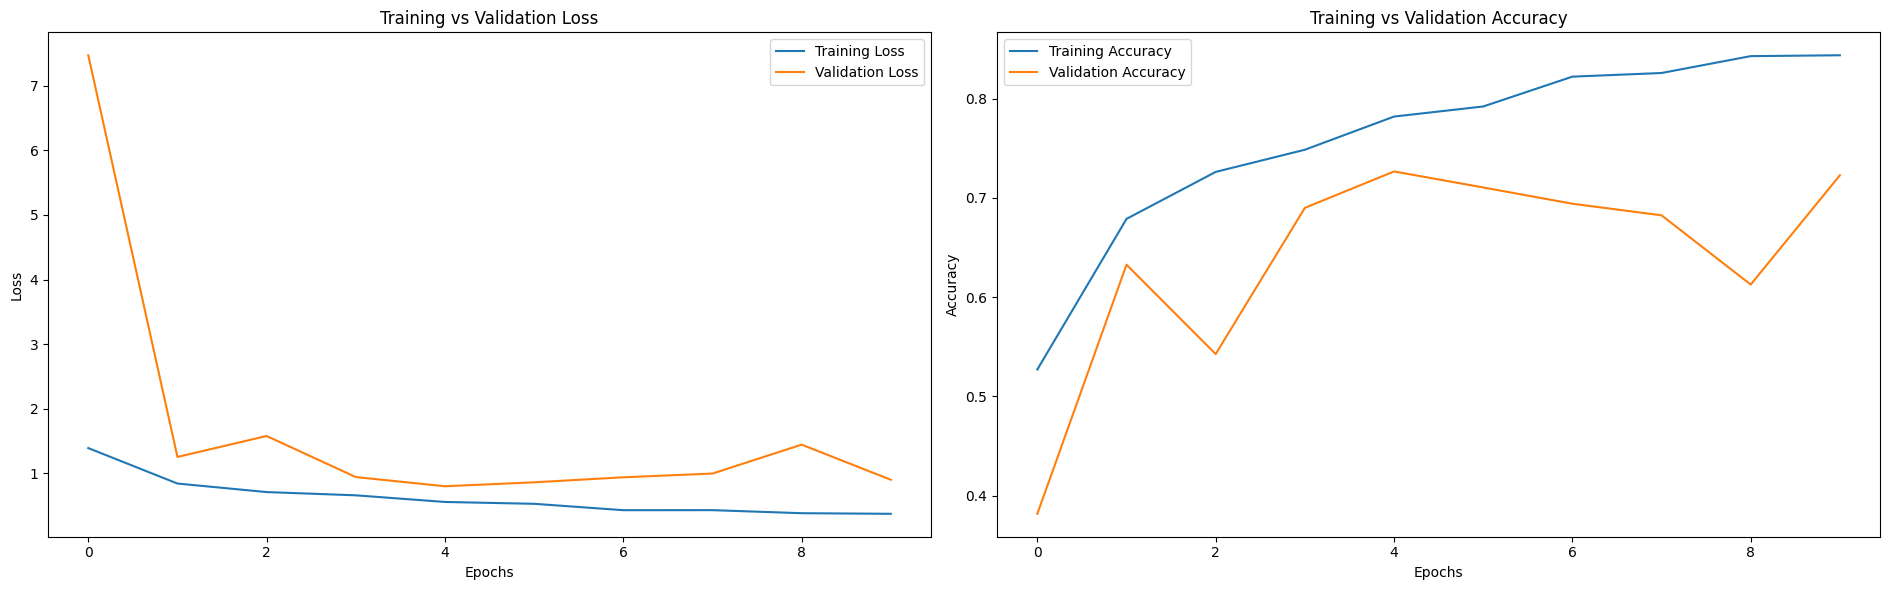

In [21]:
plt.figure(figsize=(19, 6))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [22]:
test_loss, test_acc = model.evaluate(test_ds)
print("Test Accuracy:", test_acc)
print("Test Loss:", test_loss)

114/114 ━━━━━━━━━━━━━━━━━━━━ 42s 358ms/step - accuracy: 0.7312 - loss: 0.8318
Test Accuracy: 0.7311502695083618
Test Loss: 0.8318288922309875


In [23]:
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    preds = np.argmax(preds, axis=1)

    y_true.extend(labels.numpy())
    y_pred.extend(preds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [24]:
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

Classification Report:
                           precision    recall  f1-score   support

       Cashew anthracnose       0.71      0.74      0.72       260
           Cashew gumosis       0.96      0.85      0.90        60
           Cashew healthy       0.68      0.97      0.80       206
        Cashew leaf miner       0.91      0.75      0.82       208
          Cashew red rust       1.00      0.92      0.95       253
 Cassava bacterial blight       0.96      0.51      0.67       390
       Cassava brown spot       0.60      0.98      0.74       221
       Cassava green mite       0.83      0.69      0.76       153
          Cassava healthy       0.87      0.96      0.91       180
           Cassava mosaic       0.73      0.96      0.83       168
      Maize fall armyworm       0.30      0.86      0.44        44
         Maize grasshoper       0.86      0.70      0.77       102
            Maize healthy       0.78      0.94      0.85        31
        Maize leaf beetle       0.81  

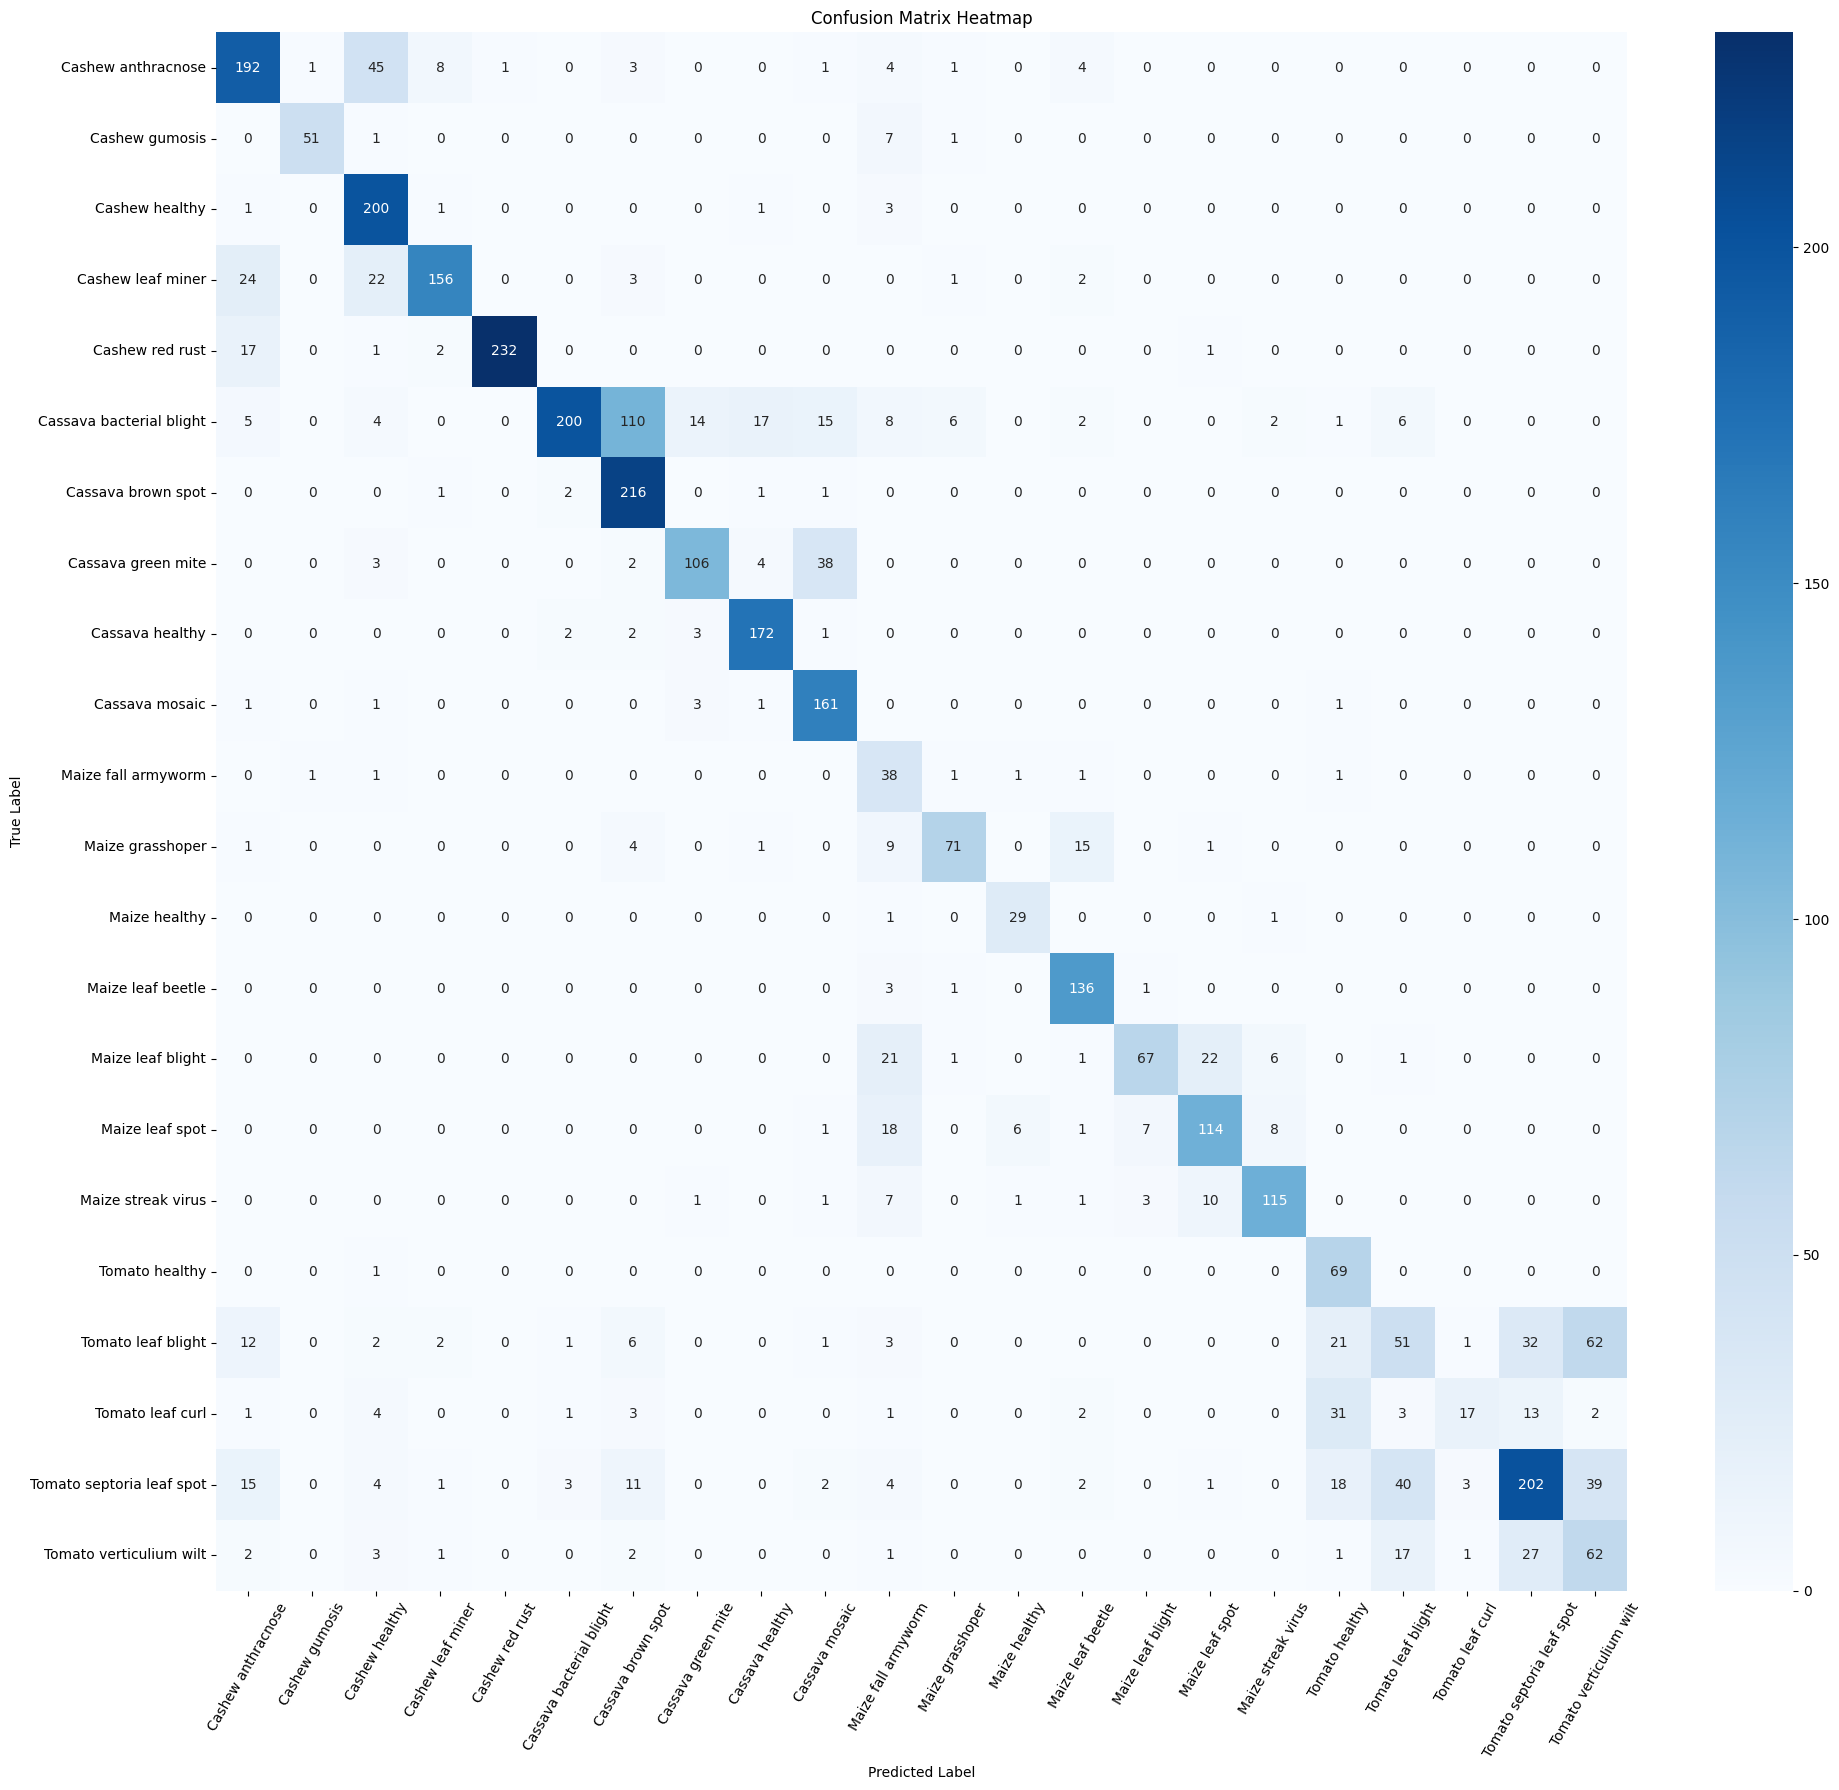

In [25]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(20, 18))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Heatmap")
plt.xticks(rotation=60)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
model.save_weights('inceptionv3.weights.h5')